# Image generation with HunyuanDIT and OpenVINO

Hunyuan-DiT is a powerful text-to-image diffusion transformer with fine-grained understanding of both English and Chinese.

![](https://raw.githubusercontent.com/Tencent/HunyuanDiT/main/asset/framework.png)

The model architecture expertly blends diffusion models and transformer networks to unlock the potential of text-to-image generation. The diffusion transformer consists of encoder and decoder blocks that work together to translate the text prompt into a visual representation. Each block contains three key modules: self-attention, cross-attention, and a feed-forward network. Self-attention analyzes relationships within the image, while cross-attention fuses the text encoding from CLIP and T5, guiding the image generation process based on the user’s input.
The Hunyuan-DiT block, specifically, consists of these encoder and decoder blocks. The encoder block processes the image patches, capturing patterns and dependencies, while the decoder reconstructs the image from the encoded information. The decoder also includes a skip module that directly connects to the encoder, facilitating information flow and enhancing detail reconstruction.
Rotary Positional Embedding (RoPE) ensures that the model understands the spatial relationships between image patches, accurately reconstructing the visual composition. Additionally, Centralized Interpolative Positional Encoding enables multi-resolution training, allowing Hunyuan-DiT to handle various image sizes seamlessly.

More details about model can be found in original [repository](https://github.com/Tencent/HunyuanDiT), [project web page](https://dit.hunyuan.tencent.com/) and [paper](https://arxiv.org/abs/2405.08748).

In this tutorial we consider how to convert and run Hunyuan-DIT model using OpenVINO. Additionally, we will use [NNCF](https://github.com/openvinotoolkit/nncf) for optimizing model in low precision.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Download PyTorch model](#Download-PyTorch-model)
- [Build PyTorch pipeline](#Build-PyTorch-pipeline)
- [Convert and Optimize models with OpenVINO and NNCF](#Convert-and-Optimize-models-with-OpenVINO-and-NNCF)
    - [DiT](#DiT)
    - [Text Encoder](#Text-Encoder)
    - [Text Embedder](#Text-Embedder)
    - [VAE Decoder](#VAE-Decoder)
- [Create Inference pipeline](#Create-Inference-pipeline)
    - [Run model](#Run-model)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/hunyuan-dit-image-generation/hunyuan-dit-image-generation.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "torch>=2.1" torchvision einops timm peft accelerate transformers diffusers huggingface-hub tokenizers sentencepiece protobuf loguru --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "nncf>=2.12" "gradio>=4.19" "pillow" "opencv-python"
%pip install -Uq "openvino>=2024.3.0"

In [2]:
from pathlib import Path
import sys

repo_dir = Path("HunyuanDiT")

if not repo_dir.exists():
    !git clone https://github.com/tencent/HunyuanDiT
    %cd HunyuanDiT
    !git checkout ebfb7936490287616c38519f87084a34a1d75362
    %cd ..

sys.path.append(str(repo_dir))

## Download PyTorch model
[back to top ⬆️](#Table-of-contents:)

For starting work with model, we should download it from HuggingFace Hub. We will use [Distilled](https://huggingface.co/Tencent-Hunyuan/Distillation) version of [hunyuan-DIT](https://huggingface.co/Tencent-Hunyuan/HunyuanDiT). In the first time, model downloading may take some time.

In [3]:
import huggingface_hub as hf_hub

weights_dir = Path("ckpts")
weights_dir.mkdir(exist_ok=True)
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

OV_DIT_MODEL = models_dir / "dit.xml"
OV_TEXT_ENCODER = models_dir / "text_encoder.xml"
OV_TEXT_EMBEDDER = models_dir / "text_embedder.xml"
OV_VAE_DECODER = models_dir / "vae_decoder.xml"

model_conversion_required = not all([OV_DIT_MODEL.exists(), OV_TEXT_ENCODER.exists(), OV_TEXT_EMBEDDER.exists(), OV_VAE_DECODER.exists()])
distilled_repo_id = "Tencent-Hunyuan/Distillation"
orig_repo_id = "Tencent-Hunyuan/HunyuanDiT"

if model_conversion_required and not (weights_dir / "t2i").exists():
    hf_hub.snapshot_download(repo_id=orig_repo_id, local_dir=weights_dir, allow_patterns=["t2i/*"], ignore_patterns=["t2i/model/*"])
    hf_hub.hf_hub_download(repo_id=distilled_repo_id, filename="pytorch_model_distill.pt", local_dir=weights_dir / "t2i/model")

## Build PyTorch pipeline
[back to top ⬆️](#Table-of-contents:)

The code bellow, initialize PyTorch inference pipeline for hunyuan-DIT model.

In [4]:
from hydit.inference import End2End
from hydit.config import get_args

gen = None

if model_conversion_required:
    args = get_args({})
    args.load_key = "distill"
    args.model_root = weights_dir

    # Load models
    gen = End2End(args, weights_dir)

/home/ea/work/notebooks_env/lib/python3.8/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


flash_attn import failed: No module named 'flash_attn'


## Convert and Optimize models with OpenVINO and NNCF
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoder to create condition to generate an image from a text prompt.
* DIT for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

For reducing model memory consumption and improving performance we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality.

Let us convert and optimize each part:

### DiT
[back to top ⬆️](#Table-of-contents:)

In [5]:
import torch
import nncf
import gc
import openvino as ov


def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


if not OV_DIT_MODEL.exists():
    latent_model_input = torch.randn(2, 4, 64, 64)
    t_expand = torch.randint(0, 1000, [2])
    prompt_embeds = torch.randn(2, 77, 1024)
    attention_mask = torch.randint(0, 2, [2, 77])
    prompt_embeds_t5 = torch.randn(2, 256, 2048)
    attention_mask_t5 = torch.randint(0, 2, [2, 256])
    ims = torch.tensor([[512, 512, 512, 512, 0, 0], [512, 512, 512, 512, 0, 0]])
    style = torch.tensor([0, 0])
    freqs_cis_img = (
        torch.randn(1024, 88),
        torch.randn(1024, 88),
    )
    model_args = (
        latent_model_input,
        t_expand,
        prompt_embeds,
        attention_mask,
        prompt_embeds_t5,
        attention_mask_t5,
        ims,
        style,
        freqs_cis_img[0],
        freqs_cis_img[1],
    )

    gen.model.to(torch.device("cpu"))
    gen.model.to(torch.float32)
    gen.model.args.use_fp16 = False
    ov_model = ov.convert_model(gen.model, example_input=model_args)
    ov_model = nncf.compress_weights(ov_model, mode=nncf.CompressWeightsMode.INT4_SYM, ratio=0.8, group_size=64)
    ov.save_model(ov_model, OV_DIT_MODEL)
    del ov_model
    cleanup_torchscript_cache()
    del gen.model
    gc.collect()

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


### Text Encoder
[back to top ⬆️](#Table-of-contents:)

In [6]:
if not OV_TEXT_ENCODER.exists():
    gen.clip_text_encoder.to("cpu")
    gen.clip_text_encoder.to(torch.float32)
    ov_model = ov.convert_model(
        gen.clip_text_encoder, example_input={"input_ids": torch.ones([1, 77], dtype=torch.int64), "attention_mask": torch.ones([1, 77], dtype=torch.int64)}
    )
    ov_model = nncf.compress_weights(ov_model, mode=nncf.CompressWeightsMode.INT4_SYM, ratio=0.8, group_size=64)
    ov.save_model(ov_model, OV_TEXT_ENCODER)
    del ov_model
    cleanup_torchscript_cache()
    del gen.clip_text_encoder
    gc.collect()

### Text Embedder
[back to top ⬆️](#Table-of-contents:)

In [7]:
if not OV_TEXT_EMBEDDER.exists():
    gen.embedder_t5.model.to("cpu")
    gen.embedder_t5.model.to(torch.float32)

    ov_model = ov.convert_model(gen.embedder_t5, example_input=(torch.ones([1, 256], dtype=torch.int64), torch.ones([1, 256], dtype=torch.int64)))
    ov_model = nncf.compress_weights(ov_model, mode=nncf.CompressWeightsMode.INT4_SYM, ratio=0.8, group_size=64)
    ov.save_model(ov_model, OV_TEXT_EMBEDDER)
    del ov_model
    cleanup_torchscript_cache()
    del gen.embedder_t5
    gc.collect()

### VAE Decoder
[back to top ⬆️](#Table-of-contents:)

In [8]:
if not OV_VAE_DECODER.exists():
    vae_decoder = gen.vae
    vae_decoder.to("cpu")
    vae_decoder.to(torch.float32)

    vae_decoder.forward = vae_decoder.decode

    ov_model = ov.convert_model(vae_decoder, example_input=torch.zeros((1, 4, 128, 128)))
    ov.save_model(ov_model, OV_VAE_DECODER)
    del ov_model
    cleanup_torchscript_cache()
    del vae_decoder
    del gen.vae
    gc.collect()

In [9]:
del gen
gc.collect();

## Create Inference pipeline
[back to top ⬆️](#Table-of-contents:)

In [10]:
import inspect
from typing import Any, Callable, Dict, List, Optional, Union

import torch
from diffusers.configuration_utils import FrozenDict
from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils.torch_utils import randn_tensor
from transformers import BertModel, BertTokenizer
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer


def rescale_noise_cfg(noise_cfg, noise_pred_text, guidance_rescale=0.0):
    """
    Rescale `noise_cfg` according to `guidance_rescale`. Based on findings of [Common Diffusion Noise Schedules and
    Sample Steps are Flawed](https://arxiv.org/pdf/2305.08891.pdf). See Section 3.4
    """
    std_text = noise_pred_text.std(dim=list(range(1, noise_pred_text.ndim)), keepdim=True)
    std_cfg = noise_cfg.std(dim=list(range(1, noise_cfg.ndim)), keepdim=True)
    # rescale the results from guidance (fixes overexposure)
    noise_pred_rescaled = noise_cfg * (std_text / std_cfg)
    # mix with the original results from guidance by factor guidance_rescale to avoid "plain looking" images
    noise_cfg = guidance_rescale * noise_pred_rescaled + (1 - guidance_rescale) * noise_cfg
    return noise_cfg


class OVHyDiTPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: Union[BertModel, CLIPTextModel],
        tokenizer: Union[BertTokenizer, CLIPTokenizer],
        unet: UNet2DConditionModel,
        scheduler: KarrasDiffusionSchedulers,
        feature_extractor: CLIPImageProcessor,
        progress_bar_config: Dict[str, Any] = None,
        embedder_t5=None,
        embedder_tokenizer=None,
    ):
        self.embedder_t5 = embedder_t5
        self.embedder_tokenizer = embedder_tokenizer

        if progress_bar_config is None:
            progress_bar_config = {}
        if not hasattr(self, "_progress_bar_config"):
            self._progress_bar_config = {}
        self._progress_bar_config.update(progress_bar_config)

        if hasattr(scheduler.config, "steps_offset") and scheduler.config.steps_offset != 1:
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if hasattr(scheduler.config, "clip_sample") and scheduler.config.clip_sample is True:
            new_config = dict(scheduler.config)
            new_config["clip_sample"] = False
            scheduler._internal_dict = FrozenDict(new_config)

        self.vae = vae
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.unet = unet
        self.scheduler = scheduler
        self.feature_extractor = feature_extractor
        self.vae_scale_factor = 2**3
        self.image_processor = VaeImageProcessor(vae_scale_factor=self.vae_scale_factor)

    def encode_prompt(
        self,
        prompt,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        embedder=None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
            embedder:
                T5 embedder
        """
        if embedder is None:
            text_encoder = self.text_encoder
            tokenizer = self.tokenizer
            max_length = self.tokenizer.model_max_length
        else:
            text_encoder = embedder
            tokenizer = self.embedder_tokenizer
            max_length = 256

        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            text_inputs = tokenizer(
                prompt,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_attention_mask=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            attention_mask = text_inputs.attention_mask

            prompt_embeds = text_encoder([text_input_ids, attention_mask])
            prompt_embeds = torch.from_numpy(prompt_embeds[0])
            attention_mask = attention_mask.repeat(num_images_per_prompt, 1)
        else:
            attention_mask = None

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif prompt is not None and type(prompt) is not type(negative_prompt):
                raise TypeError(f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !=" f" {type(prompt)}.")
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = prompt_embeds.shape[1]
            uncond_input = tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )
            uncond_attention_mask = uncond_input.attention_mask
            negative_prompt_embeds = text_encoder([uncond_input.input_ids, uncond_attention_mask])
            negative_prompt_embeds = torch.from_numpy(negative_prompt_embeds[0])
            uncond_attention_mask = uncond_attention_mask.repeat(num_images_per_prompt, 1)
        else:
            uncond_attention_mask = None

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

        return prompt_embeds, negative_prompt_embeds, attention_mask, uncond_attention_mask

    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(inspect.signature(self.scheduler.step).parameters.keys())
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(
        self,
        prompt,
        height,
        width,
        callback_steps,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)):
            raise ValueError(f"`callback_steps` has to be a positive integer but is {callback_steps} of type" f" {type(callback_steps)}.")
        if prompt is not None and prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `prompt`: {prompt} and `prompt_embeds`: {prompt_embeds}. Please make sure to" " only forward one of the two."
            )
        elif prompt is None and prompt_embeds is None:
            raise ValueError("Provide either `prompt` or `prompt_embeds`. Cannot leave both `prompt` and `prompt_embeds` undefined.")
        elif prompt is not None and (not isinstance(prompt, str) and not isinstance(prompt, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if negative_prompt is not None and negative_prompt_embeds is not None:
            raise ValueError(
                f"Cannot forward both `negative_prompt`: {negative_prompt} and `negative_prompt_embeds`:"
                f" {negative_prompt_embeds}. Please make sure to only forward one of the two."
            )

        if prompt_embeds is not None and negative_prompt_embeds is not None:
            if prompt_embeds.shape != negative_prompt_embeds.shape:
                raise ValueError(
                    "`prompt_embeds` and `negative_prompt_embeds` must have the same shape when passed directly, but"
                    f" got: `prompt_embeds` {prompt_embeds.shape} != `negative_prompt_embeds`"
                    f" {negative_prompt_embeds.shape}."
                )

    def prepare_latents(self, batch_size, num_channels_latents, height, width, dtype, generator, latents=None):
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            latents = randn_tensor(shape, generator=generator, device=torch.device("cpu"), dtype=dtype)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def __call__(
        self,
        height: int,
        width: int,
        prompt: Union[str, List[str]] = None,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        prompt_embeds_t5: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds_t5: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        guidance_rescale: float = 0.0,
        image_meta_size: Optional[torch.LongTensor] = None,
        style: Optional[torch.LongTensor] = None,
        freqs_cis_img: Optional[tuple] = None,
        learn_sigma: bool = True,
    ):
        # 1. Check inputs. Raise error if not correct
        self.check_inputs(prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds)

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.from
        do_classifier_free_guidance = guidance_scale > 1.0

        prompt_embeds, negative_prompt_embeds, attention_mask, uncond_attention_mask = self.encode_prompt(
            prompt,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )
        prompt_embeds_t5, negative_prompt_embeds_t5, attention_mask_t5, uncond_attention_mask_t5 = self.encode_prompt(
            prompt,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds_t5,
            negative_prompt_embeds=negative_prompt_embeds_t5,
            embedder=self.embedder_t5,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
            attention_mask = torch.cat([uncond_attention_mask, attention_mask])
            prompt_embeds_t5 = torch.cat([negative_prompt_embeds_t5, prompt_embeds_t5])
            attention_mask_t5 = torch.cat([uncond_attention_mask_t5, attention_mask_t5])

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=torch.device("cpu"))
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs.
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                # expand scalar t to 1-D tensor to match the 1st dim of latent_model_input
                t_expand = torch.tensor([t] * latent_model_input.shape[0], device=latent_model_input.device)

                ims = image_meta_size if image_meta_size is not None else torch.tensor([[1024, 1024, 1024, 1024, 0, 0], [1024, 1024, 1024, 1024, 0, 0]])

                noise_pred = torch.from_numpy(
                    self.unet(
                        [
                            latent_model_input,
                            t_expand,
                            prompt_embeds,
                            attention_mask,
                            prompt_embeds_t5,
                            attention_mask_t5,
                            ims,
                            style,
                            freqs_cis_img[0],
                            freqs_cis_img[1],
                        ]
                    )[0]
                )
                if learn_sigma:
                    noise_pred, _ = noise_pred.chunk(2, dim=1)

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                if do_classifier_free_guidance and guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                results = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=True)
                latents = results.prev_sample
                pred_x0 = results.pred_original_sample if hasattr(results, "pred_original_sample") else None

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents, pred_x0)

        has_nsfw_concept = None
        if not output_type == "latent":
            image = torch.from_numpy(self.vae(latents / 0.13025)[0])
        else:
            image = latents

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]

        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

### Run model
[back to top ⬆️](#Table-of-contents:)

Please select inference device using dropdown widget:

In [11]:
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [12]:
import gc
import openvino as ov

core = ov.Core()
ov_dit = core.read_model(OV_DIT_MODEL)
dit = core.compile_model(ov_dit, device.value)
ov_text_encoder = core.read_model(OV_TEXT_ENCODER)
text_encoder = core.compile_model(ov_text_encoder, device.value)
ov_text_embedder = core.read_model(OV_TEXT_EMBEDDER)

text_embedder = core.compile_model(ov_text_embedder, device.value)
vae_decoder = core.compile_model(OV_VAE_DECODER, device.value)

del ov_dit, ov_text_encoder, ov_text_embedder

gc.collect();

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./ckpts/t2i/tokenizer/")
embedder_tokenizer = AutoTokenizer.from_pretrained("./ckpts/t2i/mt5")

In [14]:
from hydit.constants import SAMPLER_FACTORY, NEGATIVE_PROMPT

In [15]:
sampler = "ddpm"
kwargs = SAMPLER_FACTORY[sampler]["kwargs"]
scheduler = SAMPLER_FACTORY[sampler]["scheduler"]

In [16]:
from diffusers import schedulers

scheduler_class = getattr(schedulers, scheduler)
scheduler = scheduler_class(**kwargs)

In [17]:
ov_pipe = OVHyDiTPipeline(vae_decoder, text_encoder, tokenizer, dit, scheduler, None, None, embedder_t5=text_embedder, embedder_tokenizer=embedder_tokenizer)

In [18]:
from hydit.modules.posemb_layers import get_2d_rotary_pos_embed, get_fill_resize_and_crop


def calc_rope(height, width, patch_size=2, head_size=88):
    th = height // 8 // patch_size
    tw = width // 8 // patch_size
    base_size = 512 // 8 // patch_size
    start, stop = get_fill_resize_and_crop((th, tw), base_size)
    sub_args = [start, stop, (th, tw)]
    rope = get_2d_rotary_pos_embed(head_size, *sub_args)
    return rope

In [19]:
from hydit.utils.tools import set_seeds

height, width = 880, 880
style = torch.as_tensor([0, 0])
target_height = int((height // 16) * 16)
target_width = int((width // 16) * 16)

size_cond = [height, width, target_width, target_height, 0, 0]
image_meta_size = torch.as_tensor([size_cond] * 2)
freqs_cis_img_cache = {}

if (target_height, target_width) not in freqs_cis_img_cache:
    freqs_cis_img_cache[(target_height, target_width)] = calc_rope(target_height, target_width)

freqs_cis_img = freqs_cis_img_cache[(target_height, target_width)]
images = ov_pipe(
    prompt="cute cat",
    negative_prompt=NEGATIVE_PROMPT,
    height=target_height,
    width=target_width,
    num_inference_steps=10,
    image_meta_size=image_meta_size,
    style=style,
    return_dict=False,
    guidance_scale=7.5,
    freqs_cis_img=freqs_cis_img,
    generator=set_seeds(42),
)

  0%|          | 0/10 [00:00<?, ?it/s]

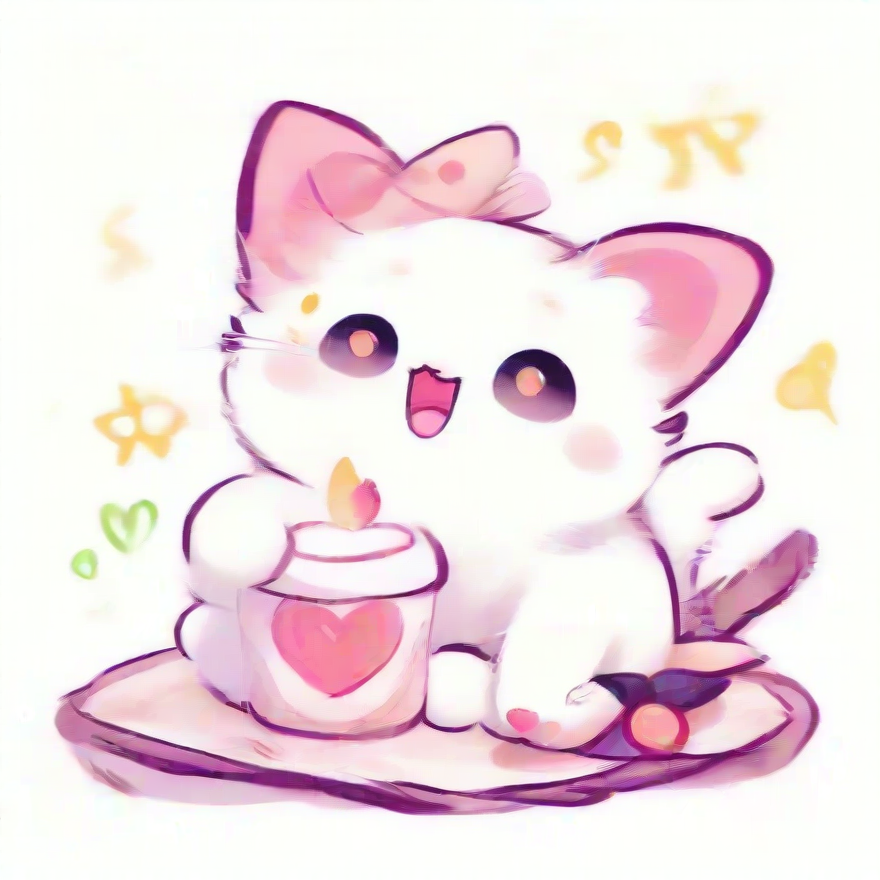

In [20]:
images[0][0]

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
import gradio as gr
import requests


def inference(input_prompt, negative_prompt, seed, num_steps, height, width, progress=gr.Progress(track_tqdm=True)):
    style = torch.as_tensor([0, 0])
    target_height = int((height // 16) * 16)
    target_width = int((width // 16) * 16)

    size_cond = [height, width, target_width, target_height, 0, 0]
    image_meta_size = torch.as_tensor([size_cond] * 2)
    freqs_cis_img = calc_rope(target_height, target_width)
    images = ov_pipe(
        prompt=input_prompt,
        negative_prompt=negative_prompt,
        height=target_height,
        width=target_width,
        num_inference_steps=num_steps,
        image_meta_size=image_meta_size,
        style=style,
        return_dict=False,
        guidance_scale=7.5,
        freqs_cis_img=freqs_cis_img,
        generator=set_seeds(seed),
    )
    return images[0][0]


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/hunyuan-dit-image-generation/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=inference)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()